In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
base_metadata_pth = Path('/Users/tsakalis/ntua/nestor/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [ ]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [215]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [245]:
gene_mutations_relevant = pd.merge(
    gene_names, gene_mutation_df, left_on=0,
    right_on='attrib_name').iloc[:, 2:].T  #.reset_index()

In [230]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

In [231]:
import torch

In [232]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [233]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [234]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [235]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [236]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]

    all_latent_df.append(latent_df)

In [237]:
pd.concat([latent_df_mean, latent_df_max], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,26.019407,0.232063,0.004331,9.803091,4.792305,7.7595,4.900111,11.990005,0.843596,6.54134,...,0.019494,0.16336,25.547979,18.863262,22.391779,0.059764,15.006134,3.261699,12.225868,19.47673


In [238]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [239]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [240]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [241]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [242]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [246]:
gene_mutated_patient = pd.merge(metadata_df,
                                gene_mutations_relevant,
                                left_on='submitter_id',
                                right_index=True)

In [247]:
gene_mutated_patient


,data_format,access,associated_entities,file_name,submitter_id,data_category,annotations,file_size,md5sum,file_id,...,30,31,32,33,34,35,36,37,38,39
0,SVS,open,[{'entity_submitter_id': 'TCGA-61-1903-01A-01-...,TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...,TCGA.61.1903,Biospecimen,"[{'entity_submitter_id': 'TCGA-61-1903', 'note...",200210513,05da084e2d65c34aa87bf865483f8b6d,13c2fa97-02ed-4442-aad8-9c4e6b365adc,...,0,0,0,0,0,0,0,0,0,0
2,SVS,open,[{'entity_submitter_id': 'TCGA-42-2587-01A-01-...,TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...,TCGA.42.2587,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2587', 'note...",138771709,c9d89dc3808a0df5bcfb7fe39994b8ca,d93b71fa-bfe0-4402-876a-b51edef5ef86,...,0,0,0,0,0,0,0,0,0,0
5,SVS,open,[{'entity_submitter_id': 'TCGA-42-2588-01A-01-...,TCGA-42-2588-01A-01-TS1.cc3b36dc-1ce9-4db3-998...,TCGA.42.2588,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2588', 'note...",116102537,9f04fbc5ce72fabcb0a1009372df12c5,525e99fd-2d3f-49b9-bf2f-bbacce843c16,...,0,0,0,0,0,0,0,0,0,0
6,SVS,open,[{'entity_submitter_id': 'TCGA-24-1416-01A-01-...,TCGA-24-1416-01A-01-BS1.9af08ca1-7925-4689-9ad...,TCGA.24.1416,Biospecimen,NaN,160023955,d3d86ff3007ce6ac4adf69bd91dee64d,3170f418-ead5-48b7-9e49-6bc256f36e75,...,0,0,0,0,0,0,0,0,0,0
7,SVS,open,[{'entity_submitter_id': 'TCGA-25-1635-01A-01-...,TCGA-25-1635-01A-01-TS1.e3fb13c5-3313-4116-9af...,TCGA.25.1635,Biospecimen,NaN,438392073,c3ab37ec807838c15042be1d5822c4da,4c90835a-125c-41a1-a2db-42d5a578c4f7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,SVS,open,[{'entity_submitter_id': 'TCGA-13-1484-01A-01-...,TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...,TCGA.13.1484,Biospecimen,NaN,271158307,17bad5ae203854c3fa27beeaeb1d51ce,a20a6cb2-2da0-491d-a22a-3bd74fb3062e,...,0,0,0,0,0,0,0,0,0,0
1365,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-BS1.e8aa0544-cc48-4941-9d7...,TCGA.13.0906,Biospecimen,NaN,175722371,dff143da3e0fb16bf4b0559a2a92af77,81a8c4e8-f40d-4e3e-b18c-f869917c50cb,...,0,0,0,0,0,0,0,0,0,0
1366,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-TS1.7be7e649-9db2-4a60-b12...,TCGA.13.0906,Biospecimen,NaN,315044077,2e9988fa5644ccd92fcc669d9d369e24,d1217464-aa0f-4f9e-aeb0-9513886939c5,...,0,0,0,0,0,0,0,0,0,0
1367,SVS,open,[{'entity_submitter_id': 'TCGA-04-1348-01A-01-...,TCGA-04-1348-01A-01-TS1.ffb07f65-72b7-494c-abf...,TCGA.04.1348,Biospecimen,NaN,109640757,1d974d73037217e9a9d97e08023d6eeb,019607b4-e183-46ee-b062-9abcbe54ceb5,...,0,0,0,0,0,0,0,0,0,0


In [243]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [244]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [248]:
all_data_mutated = pd.merge(metadata_latent,
                            gene_mutated_patient.reset_index(drop=True),
                            on='file_id',
                            how='inner')

In [251]:
all_data_mutated

,data_format_x,access_x,associated_entities_x,file_name_x,submitter_id_x,data_category_x,annotations_x,file_size_x,md5sum_x,file_id,...,30,31,32,33,34,35,36,37,38,39
0,SVS,open,[{'entity_submitter_id': 'TCGA-61-1903-01A-01-...,TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...,TCGA.61.1903,Biospecimen,"[{'entity_submitter_id': 'TCGA-61-1903', 'note...",200210513,05da084e2d65c34aa87bf865483f8b6d,13c2fa97-02ed-4442-aad8-9c4e6b365adc,...,0,0,0,0,0,0,0,0,0,0
1,SVS,open,[{'entity_submitter_id': 'TCGA-42-2587-01A-01-...,TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...,TCGA.42.2587,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2587', 'note...",138771709,c9d89dc3808a0df5bcfb7fe39994b8ca,d93b71fa-bfe0-4402-876a-b51edef5ef86,...,0,0,0,0,0,0,0,0,0,0
2,SVS,open,[{'entity_submitter_id': 'TCGA-42-2588-01A-01-...,TCGA-42-2588-01A-01-TS1.cc3b36dc-1ce9-4db3-998...,TCGA.42.2588,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2588', 'note...",116102537,9f04fbc5ce72fabcb0a1009372df12c5,525e99fd-2d3f-49b9-bf2f-bbacce843c16,...,0,0,0,0,0,0,0,0,0,0
3,SVS,open,[{'entity_submitter_id': 'TCGA-24-1416-01A-01-...,TCGA-24-1416-01A-01-BS1.9af08ca1-7925-4689-9ad...,TCGA.24.1416,Biospecimen,NaN,160023955,d3d86ff3007ce6ac4adf69bd91dee64d,3170f418-ead5-48b7-9e49-6bc256f36e75,...,0,0,0,0,0,0,0,0,0,0
4,SVS,open,[{'entity_submitter_id': 'TCGA-25-1635-01A-01-...,TCGA-25-1635-01A-01-TS1.e3fb13c5-3313-4116-9af...,TCGA.25.1635,Biospecimen,NaN,438392073,c3ab37ec807838c15042be1d5822c4da,4c90835a-125c-41a1-a2db-42d5a578c4f7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,SVS,open,[{'entity_submitter_id': 'TCGA-13-1484-01A-01-...,TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...,TCGA.13.1484,Biospecimen,NaN,271158307,17bad5ae203854c3fa27beeaeb1d51ce,a20a6cb2-2da0-491d-a22a-3bd74fb3062e,...,0,0,0,0,0,0,0,0,0,0
1067,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-BS1.e8aa0544-cc48-4941-9d7...,TCGA.13.0906,Biospecimen,NaN,175722371,dff143da3e0fb16bf4b0559a2a92af77,81a8c4e8-f40d-4e3e-b18c-f869917c50cb,...,0,0,0,0,0,0,0,0,0,0
1068,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-TS1.7be7e649-9db2-4a60-b12...,TCGA.13.0906,Biospecimen,NaN,315044077,2e9988fa5644ccd92fcc669d9d369e24,d1217464-aa0f-4f9e-aeb0-9513886939c5,...,0,0,0,0,0,0,0,0,0,0
1069,SVS,open,[{'entity_submitter_id': 'TCGA-04-1348-01A-01-...,TCGA-04-1348-01A-01-TS1.ffb07f65-72b7-494c-abf...,TCGA.04.1348,Biospecimen,NaN,109640757,1d974d73037217e9a9d97e08023d6eeb,019607b4-e183-46ee-b062-9abcbe54ceb5,...,0,0,0,0,0,0,0,0,0,0


In [269]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data_mutated.index,
                                       test_size=0.2,
                                       random_state=42)

In [253]:
target_labels = all_data.columns[-35:]

In [254]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [255]:
input_labels = [f"emb_{i}" for i in range(1024 * 4)]

In [381]:
gene_mutations_relevant.shape

(465, 40)

In [380]:
(gene_mutations_relevant == 0).sum()


0      80
1     457
2     459
3     462
4     460
5     461
6     460
7     461
8     456
9     460
10    447
11    461
12    457
13    462
14    459
15    460
16    452
17    454
18    462
19    462
20    461
21    462
22    462
23    462
24    460
25    461
26    462
27    459
28    462
29    460
30    458
31    458
32    462
33    462
34    441
35    462
36    462
37    460
38    459
39    459
dtype: int64

In [262]:
classification_labels = gene_mutations_relevant.columns

In [183]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [290]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [185]:
# pca = PCA(n_components=700)

# pcaed = pca.fit_transform(all_data[input_labels])

# all_data_copy = all_data.copy()


In [263]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [270]:
train_data_class = all_data_mutated.loc[train_ids]
test_data_class = all_data_mutated.loc[test_ids]

In [264]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [273]:
X_train, X_test = train_data_class[input_labels], test_data_class[input_labels]

In [376]:
y_class_train = train_data_class[classification_labels]
y_class_test = test_data_class[classification_labels]

In [360]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Example features and multilabel target
# X = [[0, 1], [1, 0], [0, 0], [1, 1]]  # Replace with your features
# y = [[1, 0, 1], [0, 1, 0], [1, 1, 1], [0, 0, 0]]  # Binary-encoded target

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Wrap the classifier
model = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
model.fit(scaler.fit_transform(X_train), y_class_train)

# Predict
y_pred = model.predict(scaler.transform(X_test))


/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [361]:
y_pred_proba = model.predict_proba(scaler.transform(X_test))


In [369]:
y_class_test.values.sum(axis=1)

array([1, 1, 0, 4, 4, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 3, 2, 1, 3, 1, 1,
       5, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 0, 0, 2, 1, 0, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 0,
       2, 2, 1, 1, 3, 1, 1, 1, 0, 2, 0, 1, 1, 3, 2, 1, 2, 2, 2, 2, 1, 1,
       0, 3, 2, 1, 1, 5, 1, 2, 1, 4, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 3, 0, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 2, 2, 0, 3, 1, 1, 1, 1, 1, 2, 2, 2])

In [374]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

y_pred = (y_pred_proba[:, :] > 1e-01).astype(int)
precision = precision_score(y_class_test.values, y_pred, average='samples')
recall = recall_score(y_class_test.values, y_pred, average='samples')
f1 = f1_score(y_class_test.values, y_pred, average='samples')

print(f"Precision (micro): {precision}")
print(f"Recall (micro): {recall}")
print(f"F1 Score (micro): {f1}")


Precision (micro): 0.7027131782945737
Recall (micro): 0.6468217054263565
F1 Score (micro): 0.6372978959025472


/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [366]:
from sklearn.metrics import roc_auc_score

In [375]:
for i in range(30):
    try:
        print(roc_auc_score(y_class_test.values[:, i], y_pred_proba[:, i]))
        print(y_class_test.values[:, i].sum())
    except:
        continue

0.5602110490378647
179
0.7352380952380952
5
0.8169014084507042
2
0.20597484276729564
3
0.769537480063796
6
0.4921383647798742
3
0.7887323943661972
2
0.44549763033175355
4
0.40876777251184837
4
0.5108695652173914
8
0.9788732394366197
2
0.9485981308411215
1
0.42610062893081757
3
0.8145539906103286
2
0.34976525821596244
2
0.5103668261562998
6
0.677570093457944
1
0.76056338028169
2
1.0
1
0.8925233644859814
1
0.7159624413145539
2
0.9014084507042254
2
0.7018779342723005
2
0.35062893081761004
3
0.1728971962616822
1
0.6549295774647886
2
0.4295238095238096
5
0.49289099526066354
4


In [344]:
print(classification_report(y_class_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       179
           1       0.01      0.40      0.03         5
           2       0.01      0.50      0.01         2
           3       0.00      0.00      0.00         3
           4       0.05      0.83      0.09         6
           5       0.00      0.00      0.00         0
           6       0.03      1.00      0.05         3
           7       0.02      1.00      0.04         2
           8       0.02      1.00      0.05         4
           9       0.01      0.25      0.02         4
          10       0.04      1.00      0.08         8
          11       0.01      1.00      0.03         2
          12       0.01      1.00      0.01         1
          13       0.00      0.00      0.00         0
          14       0.03      1.00      0.05         3
          15       0.02      1.00      0.03         2
          16       0.01      1.00      0.02         2
          17       0.01    

/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/nestor-FDN6wAKV-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [337]:
from sklearn.metrics import hamming_loss

# Example
hamming = hamming_loss(y_class_test, y_pred)
print(f"Hamming Loss: {hamming}")


Hamming Loss: 0.04709302325581395


In [279]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

X, y1 = make_classification(n_samples=10,
                            n_features=100,
                            n_informative=30,
                            n_classes=3,
                            random_state=1)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
Y = np.vstack((y1, y2, y3)).T
n_samples, n_features = X.shape  # 10,100
n_outputs = Y.shape[1]  # 3
n_classes = 3
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=2)
multi_target_forest.fit(X, Y).predict(X)

array([[2, 2, 0],
       [1, 2, 1],
       [2, 1, 0],
       [0, 0, 2],
       [0, 2, 1],
       [0, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 2],
       [2, 0, 0]])

In [188]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.05594927864798382


In [189]:
y_test.shape

(267, 35)

In [197]:
best_feats_idx = np.argsort(model.feature_importances_, )[-1500:]

In [198]:
num_feats = 1500

In [199]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import ExtraTreesRegressor

# rfe_selector = RFE(estimator=RandomForestRegressor(n_jobs=-1),
#                    n_features_to_select=num_feats,
#                    step=500,
#                    verbose=5)
# rfe_selector.fit(X_train, y_train)
# rfe_support = rfe_selector.get_support()
# # rfe_feature = X[corrs.dropna().index].loc[:,rfe_support].columns.tolist()
# # print(str(len(rfe_feature)), 'selected features')

In [200]:
rfe_selector.__dict__


{'estimator': RandomForestRegressor(n_jobs=-1),
 'n_features_to_select': 1500,
 'step': 500,
 'importance_getter': 'auto',
 'verbose': 5,
 'feature_names_in_': array(['emb_0', 'emb_1', 'emb_2', ..., 'emb_4093', 'emb_4094', 'emb_4095'],
       dtype=object),
 'n_features_in_': 4096}

In [201]:
rfe_support.sum()

1500

In [202]:
params_opt = {
    'n_estimators': 800,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    # 'max_features': 'sqrt'
    'max_depth': 15,
    'random_state': 42
}

In [204]:
# for i in range(len(target_labels)):
model2 = RandomForestRegressor(n_jobs=-1, **params_opt)
model2.fit(X_train.iloc[:, best_feats_idx], y_train.values.astype(float))

# Make predictions
y_pred = model2.predict(X_test.iloc[:, best_feats_idx])
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.05936386006847607


In [205]:
RandomForestRegressor?

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of decision tree
regressors on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is use

In [ ]:
# from catboost import CatBoostRegressor

# cb_reg = CatBoostRegressor(
#     objective='MultiRMSE',
#     verbose=0,
#     learning_rate=0.1,
#     n_estimators=10,
#     #    num_boost_round=10
# )
# cb_reg.fit(X_train.values, y_train)
# cb_pred = cb_reg.predict(X_test)
# # pd.DataFrame(cb_pred, columns=['Y1', 'Y2'])

In [ ]:
CatBoostRegressor?

Init signature:
CatBoostRegressor(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function='RMSE',
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    one_hot_max_size=None,
    random_strength=None,
    random_score_type=None,
    name=None,
    ignored_features=None,

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200, 500, 800],
    'max_depth': [None, 10, 15, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt']
    # 'max_features': [None, 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# RandomizedSearchCV for lightweight optimization
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=40,  # Number of parameter settings to sample
    cv=3,  # Number of folds for cross-validation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=7)

# Fit the random search to the data
random_search.fit(X_train.iloc[:, best_feats_idx],
                  y_train.values)  # Flatten y_train for regression

# Best parameters and evaluation
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
y_pred = best_model.predict(X_test.iloc[:, best_feats_idx])
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
R2 Score: 0.048403477817215115
Mean Squared Error: 0.3238247359638796


In [ ]:
y_train.shape

(564, 35)

In [77]:
y_pred_flat.shape

NameError: name 'y_pred_flat' is not defined

In [78]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [206]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])

In [207]:
sorted(correls)[::-1]

[0.532343066625017,
 0.4998451183332849,
 0.4791750930195289,
 0.424316262089395,
 0.37969282760017437,
 0.3725424264857419,
 0.35679055664008863,
 0.3335979753419603,
 0.33101229818655536,
 0.3303742279484113,
 0.3021164191132617,
 0.2814560107701296,
 0.28089239562692536,
 0.27584199368032275,
 0.2719056405785089,
 0.2621662495600402,
 0.26016580229959685,
 0.25631683504217867,
 0.24353831313924892,
 0.24047544946621743,
 0.23943513461783347,
 0.22543077575224882,
 0.21154190630640807,
 0.19604589265122488,
 0.19300116538433845,
 0.1836670787418045,
 0.18049362458278376,
 0.17199474061621373,
 0.1710550619950588,
 0.08268738800185665,
 0.07734362962675527,
 0.07179158091095654,
 0.05859976025410641,
 0.03177364923453057,
 -0.01804273530341289]

In [208]:
# for i in range(len(target_labels)):
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train.values[:, i])

#     # Make predictions
#     y_pred = model.predict(X_test)
#     # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
#     print(r2_score(y_test.values[:, i], y_pred))
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten())[0, 1])

In [209]:
y_test.values.flatten()

array([7.3557, 6.2354, 8.0047, ..., 6.9324, 7.5566, 6.9458], dtype=object)

In [210]:
y_pred.flatten()

array([7.02772916, 5.39204192, 7.94196365, ..., 6.54963458, 7.77956702,
       7.05057738])

In [211]:
y_test.shape

(267, 35)

In [212]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

In [213]:
gene_names.iloc[genes][0].values

array(['FGFR2', 'EGFR', 'RNF43', 'PPP2R1A', 'ERBB4', 'RAC1', 'EZH2',
       'GNAQ', 'MAPK1', 'PTCH1', 'MYCN', 'TOP1', 'BRAF', 'NOTCH2',
       'MYD88', 'CDK6', 'NTRK1', 'TSC2', 'BTK', 'CBL', 'NFE2L2', 'AKT2',
       'CHEK2', 'CREBBP', 'MYC', 'MAGOH', 'PDGFRA', 'ATM', 'DDR2',
       'NOTCH3', 'ARID1A', 'GNA11', 'HRAS', 'SMARCB1', 'MAP2K2'],
      dtype=object)

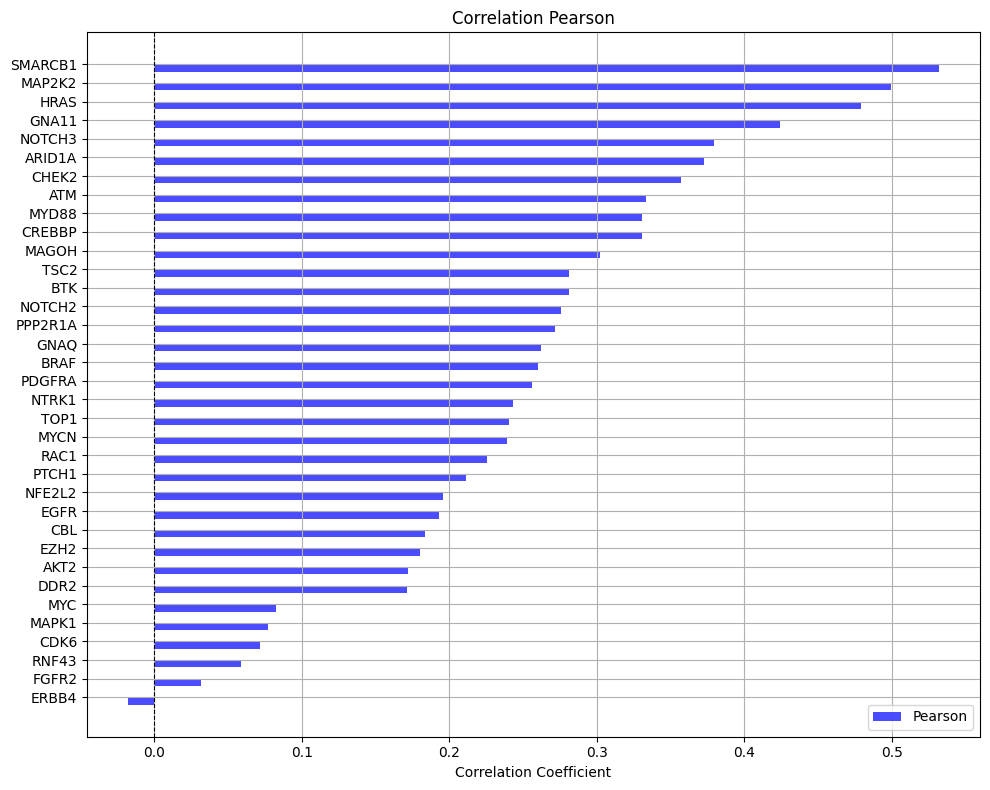

In [214]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)  #[::-1]
genes = np.array(target_labels)[sort_idx]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, gene_names.iloc[genes][0].values)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)